In [1]:
import json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import re 
import spotlight
import requests
import tensorflow as tf
from random import sample
import sparql
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
import spacy
nlp = spacy.load('en_core_web_lg')

# SimpleDBpediaQA

In [3]:
#Load data

with open('data/SimpleDBpediaQA/train.json') as f:
    train = json.load(f)
with open('data/SimpleDBpediaQA/test.json') as f:
    test = json.load(f)
with open('data/SimpleDBpediaQA/valid.json') as f:
    valid = json.load(f)



In [4]:
train_df = pd.DataFrame(train['Questions'])
valid_df = pd.DataFrame(valid['Questions'])
test_df = pd.DataFrame(test['Questions'])

In [5]:
#Merge all data from SimpleDBpediaQA to filter questions related to books
simple_df = pd.concat([train_df, valid_df, test_df])

In [6]:
simple_df

,ID,Query,Subject,FreebasePredicate,PredicateList
0,00007,what movie is produced by warner bros.,http://dbpedia.org/resource/Warner_Bros.,www.freebase.com/film/production_company/films,[{'Predicate': 'http://dbpedia.org/ontology/di...
1,00008,What is don graham known as?,http://dbpedia.org/resource/Don_Graham_(Americ...,www.freebase.com/common/topic/notable_types,[{'Predicate': 'http://purl.org/linguistics/go...
2,00009,what's there to see in columbus,"http://dbpedia.org/resource/Columbus,_Ohio",www.freebase.com/travel/travel_destination/tou...,[{'Predicate': 'http://dbpedia.org/ontology/lo...
3,00011,who is a musician born in detroit,http://dbpedia.org/resource/Detroit,www.freebase.com/location/location/people_born...,[{'Predicate': 'http://dbpedia.org/ontology/bi...
4,00012,Which city did the artist ryna originate in,http://dbpedia.org/resource/RYNA,www.freebase.com/music/artist/origin,[{'Predicate': 'http://dbpedia.org/ontology/ho...
...,...,...,...,...,...
8590,21676,What is sandy herd's position?,http://dbpedia.org/resource/Sandy_Herd_(footba...,www.freebase.com/soccer/football_player/positi...,[{'Predicate': 'http://dbpedia.org/ontology/po...
8591,21677,what kind of mountain is chiles,http://dbpedia.org/resource/Chiles_(volcano),www.freebase.com/geography/mountain/mountain_type,[{'Predicate': 'http://dbpedia.org/ontology/ty...
8592,21678,Where was gunnar johansen born in Denmark?,http://dbpedia.org/resource/Gunnar_Johansen,www.freebase.com/people/person/place_of_birth,[{'Predicate': 'http://dbpedia.org/ontology/bi...
8593,21679,where in the us is fontana located,"http://dbpedia.org/resource/Fontana,_California",www.freebase.com/location/location/containedby,[{'Predicate': 'http://dbpedia.org/ontology/is...


In [7]:
simple_df.isna().sum()

ID                   0
Query                0
Subject              0
FreebasePredicate    0
PredicateList        0
dtype: int64

In [8]:
#dictionary of conversion from Freebase to DBpedia
pred_dict = {}
for key, value in zip(simple_df['FreebasePredicate'], simple_df['PredicateList']):
    pred_dict[key] = value[0]['Predicate']

In [9]:
#DBpedia predicates to be filtered
ont_list = ['http://dbpedia.org/ontology/notableWork', 'http://dbpedia.org/ontology/WrittenWork', 'http://dbpedia.org/ontology/author' , 'http://dbpedia.org/ontology/publisher',  'http://dbpedia.org/ontology/subsequentWork', 'http://dbpedia.org/ontology/Country', 'http://dbpedia.org/property/author', 'http://dbpedia.org/ontology/illustrator', 'http://dbpedia.org/property/notableworks>', 'http://dbpedia.org/ontology/nationality', 'http://dbpedia.org/ontology/releaseDate', 'http://dbpedia.org/ontology/birthDate', 'http://dbpedia.org/ontology/birthName', 'http://dbpedia.org/ontology/birthPlace', 'http://dbpedia.org/ontology/occupation', 'http://dbpedia.org/ontology/influencedBy', 'http://dbpedia.org/ontology/literaryGenre', 'http://dbpedia.org/ontology/country','http://dbpedia.org/ontology/notableWork', 'http://dbpedia.org/ontology/previousWork']


In [10]:
#dictionary of freebase and DBpedia translation filtered
for key, value in pred_dict.items():
    if value in ont_list:  
        print(key + ' --> ' + value)
    

www.freebase.com/location/location/people_born_here --> http://dbpedia.org/ontology/birthPlace
www.freebase.com/people/person/nationality --> http://dbpedia.org/ontology/nationality
www.freebase.com/influence/influence_node/influenced --> http://dbpedia.org/ontology/influencedBy
www.freebase.com/book/author/works_written --> http://dbpedia.org/ontology/author
www.freebase.com/people/person/place_of_birth --> http://dbpedia.org/ontology/birthPlace
www.freebase.com/book/book/genre --> http://dbpedia.org/ontology/literaryGenre
www.freebase.com/book/written_work/author --> http://dbpedia.org/ontology/author
www.freebase.com/tv/tv_program/country_of_origin --> http://dbpedia.org/ontology/country
www.freebase.com/cvg/computer_videogame/publisher --> http://dbpedia.org/ontology/publisher
www.freebase.com/film/film/country --> http://dbpedia.org/ontology/country
www.freebase.com/media_common/literary_genre/books_in_this_genre --> http://dbpedia.org/ontology/literaryGenre
www.freebase.com/cvg/c

In [11]:
#replace entity by their label
def replace_entity(data_list):
    replace_list = []
    for question in data_list:
        doc = nlp(question)
        for ent in doc.ents:
          
            #ent_label = str(ent.label_)
            ent_label = 'ENT'
            question = question.replace(question[ent.start_char:ent.end_char], ent_label)
            replace_list.append(question)
    return replace_list

In [12]:
#function to filter predicate based on regex exp
def regex_filter(exp,val):
    if val:
        regex = re.search(exp,val)
        if regex:
            return True
        else:
            return False
    

In [13]:
#transform predicate to a domain filter by the first word after www.freebase.com/
simple_df['theme'] = simple_df['FreebasePredicate']
simple_df['theme'] = simple_df['theme'].str.replace("www.freebase.com/","")
simple_df['theme'] = simple_df['theme'].apply(lambda x : re.sub(r"(/.*)", '', x))

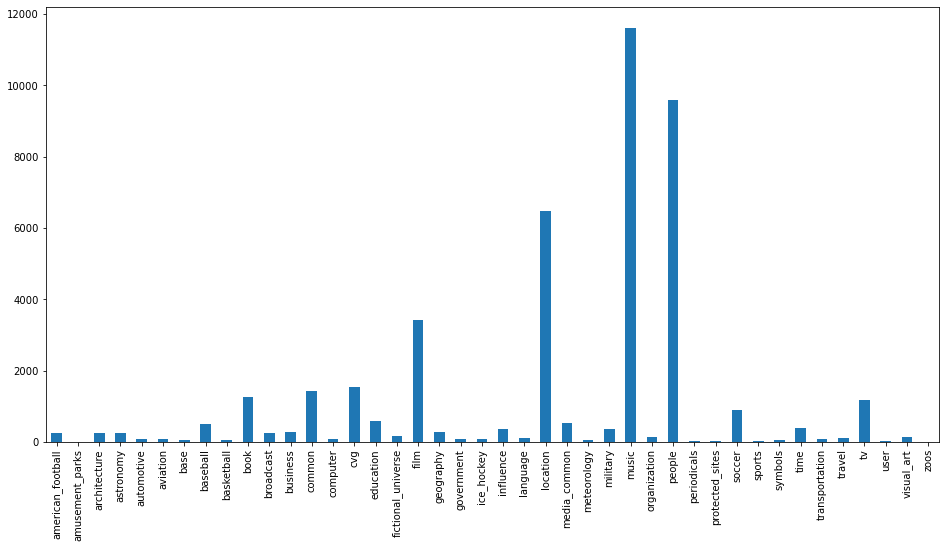

In [14]:
#distribution plot of simple_df by domain
fig = plt.figure(figsize=(16,8))
ax = simple_df['theme'].value_counts().sort_index(ascending=True)
ax.plot(kind='bar')
fig.savefig('images/simple_theme.png', bbox_inches = 'tight')

In [ ]:
#sentence length of SimpleDbpediaQA dataset
fig = plt.figure(figsize=(12,6))
plt.hist([len(question.split()) for question in simple_df['Query'] ], bins= 25)
fig.savefig('images/len_question_all.png')

## Book questions of SimpleDBpediaQA

In [ ]:
#predicates related to books, but not contain in freebase book domain. Some of them are not directly related to books, but tha amount of available question shouldn't affect the classification
pred_book = ['www.freebase.com/media_common/literary_genre/books_in_this_genre', 'www.freebase.com/cvg/computer_videogame/publisher']

In [ ]:
#select predicates related to freebase domain books
book_set = set([pred for pred in simple_df['FreebasePredicate'] if regex_filter(r'^www.freebase.com/book(.*)', pred) == True])

In [ ]:
publisher_list = simple_df['Query'][simple_df['FreebasePredicate'] == 'www.freebase.com/cvg/computer_videogame/publisher']

In [ ]:
#get similarity between a target type of questions and an input question
def make_similar(reference, input_q):
    q_vec = []
    input_vec = nlp(input_q)

    for question in reference:
        question_vec = nlp(question)
        q_vec.append(input_vec.similarity(question_vec))
        return max(q_vec)

In [ ]:
publisher_target = ['who is the publisher', 'who published', 'who released', 'what company published', 'what company released']

In [ ]:

fig = plt.figure(figsize=(12,6))
plt.hist([make_similar(publisher_target, input_) for input_ in publisher_list], bins= 10)
fig.savefig('images/publisher_question_all.png')

In [ ]:
#filtering predicates relating to newspaper.
book_set = ['www.freebase.com/book/written_work/original_language',
 'www.freebase.com/book/book/genre',
 'www.freebase.com/book/author/works_written',
 'www.freebase.com/book/written_work/author']

In [ ]:
#Drop predicates related to newspapers and add other type of predicates not directely related to book domain, but can be asked
book_filter = book_set + pred_book
book_filter

In [ ]:
#filtering dataset to the selected predicates
train_book = train_df[train_df['FreebasePredicate'].isin(book_filter)]
valid_book = valid_df[valid_df['FreebasePredicate'].isin(book_filter)]
test_book = test_df[test_df['FreebasePredicate'].isin(book_filter)]

In [ ]:
#merge train, valid and test of the subset
simple_df_book = pd.concat([train_book, test_book, valid_book])
simple_df_book = simple_df_book.reset_index(drop=True)
simple_df_book

In [ ]:
simple_df_book['FreebasePredicate'].value_counts()

In [ ]:
#use predicate from Freebase to identify intents
simple_df_book['FreebasePredicate'].loc[simple_df_book['FreebasePredicate'] == 'www.freebase.com/book/book/genre'] = 'genre'
simple_df_book['FreebasePredicate'].loc[simple_df_book['FreebasePredicate'] == 'www.freebase.com/media_common/literary_genre/books_in_this_genre'] = 'books_in_genre'
simple_df_book['FreebasePredicate'].loc[simple_df_book['FreebasePredicate'] == 'www.freebase.com/book/written_work/author'] = 'author_of_book'
simple_df_book['FreebasePredicate'].loc[simple_df_book['FreebasePredicate'] == 'www.freebase.com/book/author/works_written'] = 'book_from_author'
simple_df_book['FreebasePredicate'].loc[simple_df_book['FreebasePredicate'] == 'www.freebase.com/book/written_work/original_language'] = 'language'
simple_df_book['FreebasePredicate'].loc[simple_df_book['FreebasePredicate'] == 'www.freebase.com/cvg/computer_videogame/publisher'] = 'publisher'



In [ ]:
len(simple_df_book)/len(simple_df)

In [ ]:
#distribution plot of filtered dataset
fig = plt.figure(figsize=(12,6))
ax = simple_df_book['FreebasePredicate'].value_counts().sort_index(ascending=True)
ax.plot(kind='bar')
fig.savefig('images/data_book.png', bbox_inches = 'tight')

In [ ]:
#question length for subset dataset -> change to complete dataset
fig = plt.figure(figsize=(10,6))
plt.hist([len(question.split()) for question in simple_df_book['Query']], bins= 15)
fig.savefig('images/len_question.png')

In [ ]:
simple_df_book.to_csv('data_outputs/book_df.csv', index=False)

## Improving dataset of books by question generation of abstracts of books in DBpedia

In [ ]:
#create a dataframe from abstracts
abstract_query = sparql.query('http://dbpedia.org/sparql', """SELECT DISTINCT ?s ?label
WHERE {  ?s rdf:type dbo:Book .
  ?s dbo:abstract ?label .
    FILTER (lang(?label) = 'en')}
""") 

In [ ]:
abstract_list = []
for row in abstract_query:
    values = sparql.unpack_row(row)
    abstract_list.append(values)
abstract_df = pd.DataFrame(abstract_list, columns=['book', 'abstract'])
abstract_df.head()

In [ ]:
#load question generated from abstracts
import json

with open('/home/aliciescont/Documents/tfm_code/question_generation/abstract.json') as f:
    abstract = json.load(f)

In [ ]:
#get similarity between a target type of questions and an input question
def make_similar(reference, input_q):
    q_vec = []
    input_vec = nlp(input_q)

    for question in reference:
        question_vec = nlp(question)
        q_vec.append(input_vec.similarity(question_vec))
        return max(q_vec)
        

In [ ]:
#get generated question
question_list = []

for qg in abstract.values():
    for question in qg:
        question_list.append(question)
        doc1= nlp(question)


In [ ]:
len(question_list)

In [ ]:
#lang_question = simple_df_book['Query'][simple_df_book['FreebasePredicate']=='language'].to_list()
lang_question = [ "what language was", "in which language is written","what is the original language of", "in what language was realeased", "in what language was published", "what language was translated into"]

In [ ]:
lang_similarity = [make_similar(lang_question, input_) for input_ in question_list]

In [ ]:
lang_df= pd.DataFrame(zip(question_list, lang_similarity), columns=['question', 'similarity'])
lang_df = lang_df['question'][lang_df['similarity']>0.88]

In [ ]:
lang_list = []
for question in lang_df:
    for word in question.split():
        if word in ['language', 'languages']:
            lang_list.append(question)

In [ ]:
lang_df = pd.DataFrame(lang_list, columns=['Query'])

In [ ]:

lang_df = pd.DataFrame(lang_list[1:], columns=['Query'])
lang_df['pred'] = 'language'

In [ ]:
date_questions = ['when was published', 'when was released', 'when was written','when came out', 'in what date was published', 'in what year was published', 'what is the publication date']

In [ ]:
date_similarity = [make_similar(date_questions, input_) for input_ in question_list]

In [ ]:
date_df= pd.DataFrame(zip(question_list, date_similarity), columns=['Query', 'similarity'])
date_df = date_df[date_df['similarity']>0.89]

In [ ]:
date_list = set(date_df['Query'].to_list())

In [ ]:
date_list = []
for question in date_df['Query'].to_list():
    for word in question.split():
        if word.lower() != 'where':
            date_list.append(question)

In [ ]:
date_list = set(date_list)

In [ ]:

date_df = pd.DataFrame(date_list, columns=['Query'])
date_df['pred'] = 'date'

In [ ]:
country_df = pd.DataFrame(simple_df['Query'][simple_df['FreebasePredicate'] == 'www.freebase.com/film/film/country'])
country_df['pred'] = 'country'


In [ ]:
country_df

In [ ]:
intent_simple_df = simple_df_book[['Query', 'FreebasePredicate']]
intent_simple_df.columns = ['Query', 'pred']

In [ ]:
final_df = pd.concat([intent_simple_df, date_df, lang_df, country_df])

In [ ]:
intent_simple_df['pred'].value_counts()

In [ ]:
final_df['pred'].value_counts()

In [ ]:
len(set(replace_entity(final_df['Query'][final_df['pred']=='genre'])))

In [ ]:
#distribution plot of filtered dataset -> change to complete dataset
fig = plt.figure(figsize=(12,6))
ax = final_df['pred'].value_counts().sort_index(ascending=True)
ax.plot(kind='bar')
fig.savefig('images/data_book_final.png', bbox_inches = 'tight')

In [ ]:
final_df

In [ ]:
np.mean([len(question) for question in final_df['Query']])

In [ ]:
#question length for subset dataset -> change to complete dataset
fig = plt.figure(figsize=(10,6))
plt.hist([len(question) for question in final_df['Query']], bins= 50)
fig.savefig('len_question_book.png')

In [ ]:
final_df['pred'].value_counts()

In [ ]:
final_df.to_csv('data_outputs/final_intent_df.csv', index = False)

In [ ]:
final_df

# NEL

In [ ]:
def NEL_spotlight(question, support):

    question_annotations = []
    try: 
        annotations = spotlight.annotate('https://api.dbpedia-spotlight.org/en/annotate', question, confidence=0.4, support=20) 
        question_annotations.append(annotations[0]['URI']) 
    except:
        pass

    return question_annotations[0]

In [ ]:
def tagme_annotation(token, question):
    ann_list = []
    response = requests.get("https://tagme.d4science.org/tagme/tag?lang=en&gcube-token={}&text={}".format(token, question))

    annotations = {}
    if response.status_code == 200 :
      for annotation in json.loads(response.text)['annotations']: 
             
        annotations[('http://dbpedia.org/resource/' + annotation['title'].replace(' ', '_'))] = annotation['rho']
    else: 
      annotations.append('')

    return sorted(annotations.items(), key=lambda x: x[1])[-1]

In [ ]:
spot = NEL_spotlight("who is the author of harry potter",0.4) 

In [ ]:
tagme_annotation(TOKEN, "WHO IS THE AUTHOR OF HARRY POTTER")

In [ ]:
TOKEN = "f70577ab-c371-4fb8-83f3-e82791f9b1a1-843339462"


In [ ]:
%%time
NEL_spotlight(simple_df_book['Query'][0])

In [ ]:
%%time
book_spot = [NEL_spotlight(question) for question in simple_df_book['Query']]

In [ ]:
%%time
book_tagme = [tagme_annotation(TOKEN, question)[0] for question in simple_df_book['Query']]

In [ ]:
def qa_pred (data, pred):
    true = []
    not_ent = []
    for i in range(len(data)):
        if pred[i] == ' ':
            true.append(0.0)
            not_ent.append(1.0)
        elif pred[i] == data[i] and pred[i]!= '':
            true.append(1.0)
        else:
            true.append(0.0)

    fp = len(data)-sum(not_ent)-sum(true)
    fn = len(data)-sum(not_ent)
    recall = sum(true)/(sum(true)+fn)
    precision = sum(true)/(sum(true)+fp)
    return recall, precision, sum(true), fp, fn

In [ ]:
#books_df + prediction from DBpedia Spotlight and TAgMe
nel_df = pd.read_csv('data_outputs/nel_data.csv')

In [ ]:
nel_df.columns

In [ ]:
qa_pred(simple_df_book['Subject'], nel_df['tagme'])

# Intent recognition

In [ ]:
final_df

In [ ]:
final_df['pred'].value_counts()

In [ ]:

from transformers import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [ ]:
input_ids = []
attention_masks = []

for question in final_df['Query']:
  enc_question = tokenizer.encode_plus(question, add_special_tokens= True, max_length=24, pad_to_max_length = True, return_attention_mask = True)
  input_ids.append(enc_question['input_ids'])
  attention_masks.append(enc_question['attention_mask'])

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)


In [ ]:
vocab_size = tokenizer.vocab_size
max_len = max([len(question) for question in input_ids])

In [ ]:
max_len

In [ ]:
encoder = LabelEncoder()
intent_val = encoder.fit_transform(final_df['pred'])

In [ ]:
set(intent_val)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, train_mask, val_mask = train_test_split(input_ids , intent_val, attention_masks , random_state=42, test_size = 0.2)

In [ ]:
vocab_size = tokenizer.vocab_size + 1
embedding_dim = 128

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_len),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    
    tf.keras.layers.Dense(8, activation = 'softmax')])
  

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=2e-4), metrics=['acc'])
model.summary()

In [ ]:
history = model.fit(x_train, y_train,epochs = 10, validation_data=(x_test, y_test), verbose = 1, batch_size = 32)

In [ ]:
import tensorflow as tf
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_len),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation = 'softmax')], name = 'LSTM')
  

lstm_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=2e-4), metrics=['acc'])
lstm_model.summary()

In [ ]:
from sklearn.utils import class_weight
class_weight = list(class_weight.compute_class_weight('balanced', np.unique(final_df['pred']), final_df['pred']))

In [ ]:
final_df['pred'].value_counts()

In [ ]:
weights = {}
for idx, weight in enumerate(class_weight):
    weights[idx] = weight

In [ ]:
weights

In [ ]:
history = lstm_model.fit(x_train, y_train,epochs = 10, validation_data=(x_test, y_test), verbose = 1, batch_size = 32, class_weight=weights)

In [ ]:
from keras.utils import to_categorical
question_test  = "who is the publisher of harry potter" 
q_test_enc = tokenizer.encode(question_test, add_special_tokens= True)



In [ ]:

preds = model.predict_classes(q_test_enc)
prediction_ = np.argmax(preds, axis=-1)
encoder.inverse_transform([0])

In [ ]:
from sklearn.metrics import classification_report
preds = model.predict_classes(x_test)
print(classification_report(y_test, preds,target_names = encoder.inverse_transform([i for i in range(8)])))


In [ ]:
y_pred = model.predict_classes(x_test)

In [ ]:
np.unique(final_df['pred'])

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()
#plt.savefig('accuracy.jpeg')


In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()
#plt.savefig('loss.png')

In [ ]:
model.save('bilstm')

In [ ]:
bilstm_model = tf.keras.models.load_model('bilstm')

In [ ]:
bilstm_model.predict(q_test_enc)